## MCMC

tinyDA can be pip installed

### Problem setup

In this example we solve...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.spatial import distance_matrix

import tinyDA as tda
import umbridge

/home/anne/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Ray module not found. Multiprocessing features are not available


In [2]:
np.random.seed(111)

### Initialising UM-Bridge
Before running the following cell, the model Docker image must be started from a system terminal using 
`docker run -it -p 4242:4242 acousticgravity`

In [22]:
# connect to the UM-Bridge model.
umbridge_model = umbridge.HTTPModel('http://localhost:4242', "forward")

# wrap the UM-Bridge model in the tinyDA UM-Bridge interface.
pre = lambda x: x
my_model = tda.UmBridgeModel(umbridge_model, pre=pre)

### Problem setup

In [23]:
# get the number of inputs and outputs.
nx = umbridge_model.get_input_sizes()[0] #the input is the location in x of the jump discontinuity
ny = umbridge_model.get_output_sizes()[0] #the outout is a time series of the pressure

In [27]:
# convert NumPy array to standard UM-Bridge input.
parameters = np.ndarray(nx)
parameters[0] = 0.5
#umbridge_input = [pre(parameters).tolist()]

# send converted model input the the UM-Bridge model.
umbridge_output = my_model(parameters)

# convert the UM-Bridge output back to a NumPy array.
model_output = np.array(umbridge_output).flatten()

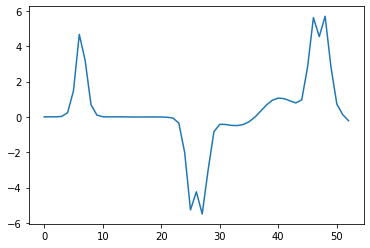

In [28]:
plt.plot(model_output)
plt.show()

In [29]:
# set the prior mean and covariance.
mean_prior = np.zeros(nx)
cov_prior = np.eye(nx)

# set the covariance of the likelihood.
sigma_noise = 0.1
cov_likelihood = sigma_noise**2*np.eye(model_output.shape[0])

# initialise the prior distribution and likelihood.
my_prior = multivariate_normal(mean_prior, cov_prior)
my_loglike = tda.GaussianLogLike(model_output, cov_likelihood)

In [31]:
# generate a draw from the prior and pass it through the model
log_true = my_prior.rvs()

d_true = my_model(log_true)

# add some noise to the model output
d = d_true + np.random.normal(loc=0, scale=sigma_noise, size=ny)

In [33]:
# initialise the Posterior
my_posterior = tda.Posterior(my_prior, my_loglike, my_model)

### Set up the proposal

In [34]:
# preconditioned Crank-Nicolson
pcn_scaling = 0.1
pcn_adaptive = True
my_proposal = tda.CrankNicolson(scaling=pcn_scaling, adaptive=pcn_adaptive)

### Sample

In [35]:
# For testing purposes, iteration number is small for the given problem; Choose a larger number for real applications.
my_chains = tda.sample(my_posterior, my_proposal, iterations=100, n_chains=1, force_sequential=True)

Sampling chain 1/1


Running chain, α = 1.00:   4%|█████▉                                                                                                                                               | 4/100 [00:01<00:33,  2.91it/s]/home/anne/.local/lib/python3.10/site-packages/tinyDA/proposal.py:340: RuntimeWarning: overflow encountered in exp
  return np.exp(proposal_link.likelihood - previous_link.likelihood)
Running chain, α = 0.10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.80it/s]


### Get some diagnostics

In [ ]:
import arviz as az

In [ ]:
# convert the tinyDA chains to an ArViz InferenceData object.
idata = tda.to_inference_data(my_chains, burnin=10)

In [ ]:
# display posterior summary statistics.
az.summary(idata)

In [ ]:
# plot posterior kernel densities and traces.
az.plot_trace(idata)
plt.show()

In [ ]:
# extract the parameters from the chains.
parameters = [link.parameters for link in my_chains['chain_0'][2001:] + my_chains['chain_1'][2001:]]

In [ ]:
# plot some posterior draws of the model input and output.
n_samples = 1000
ids = np.random.randint(0, len(parameters), n_samples)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

# plot the stiffness.
ax[0].set_title('Stiffness')
ax[0].plot(x, E(log_E_true))
for i in ids:
    ax[0].plot(x, E(parameters[i]), c='k', alpha=0.01)

# plot the deflection
ax[1].set_title('Deflection')
ax[1].plot(x, d)
for i in ids:
    ax[1].plot(x, my_model(parameters[i]), c='k', alpha=0.01)
plt.show()

## Bayesian filtering

In [ ]:
from pfilter import ParticleFilter, independent_sample, squared_error
from scipy.stats import norm, gamma, uniform 
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [ ]:
def apply_filter(pf, ys, inputs=None):
    """Apply filter pf to a series of observations (time_steps, h)  and return a dictionary:    
        particles: an array of particles (time_steps, n, d)
        weights: an array of weights (time_steps,)        
    """

    states = []
    pf.init_filter()  # reset
    for i,y in enumerate(ys):
        if inputs is None:
            pf.update(y)
        else:
            pf.update(y, **inputs[i])
            
        states.append([pf.transformed_particles, np.array(pf.weights)])
    return {
        name: np.array([s[i] for s in states])
        for i, name in enumerate(["particles", "weights"])
    }

In [ ]:
def plot_particles(x, y, yn, states):
    """Plot a 1D tracking result as a line graph with overlaid
    scatterplot of particles. Particles are sized according to
    normalised weight at each step.
    
        x: time values
        y: original (uncorrupted) values
        yn: noisy (observed) values
        states: dictionary return from apply_pfilter        
    """
    fig, ax = plt.subplots()
    ax.plot(x, y, label='True', lw=1)
    ax.plot(x, yn, label='Noisy', lw=2)
    
    particles = states["particles"]
    ws = states["weights"]    
    means = np.sum(particles[:,:,0] * ws, axis=1)
    
    dev = (means - (particles[:,:,0]).T).T**2
    var = np.sum(ws * dev, axis=1)  / 1-np.sum(ws**2)  # unbiased variance
    stds = np.sqrt(var)
    
    ax.plot(x, means, 'C4', label='Mean est.', lw=4)
    ax.fill_between(x, means-stds, means+stds, color='C4', alpha=0.5, label='Std.')
    ax.scatter(np.tile(x, (len(particles[0]),1)).ravel(), particles[:,:,0].T, s=ws*1000/np.sqrt(len(ws)),
                alpha=0.15, label='Particles')
    ax.set_xlabel("Time")
    ax.set_ylabel("Observed")
    ax.legend()
    
def filter_plot(x, y, yn, pf, inputs=None):
    """Apply a filter to yn, and plot the results using plot_particles()"""
    states = apply_filter(pf, yn, inputs)
    plot_particles(x, y, yn, states)

In [ ]:
# Noisy sine wave data
x = np.linspace(0, 100, 100)
y = np.cos(x/4.0) + x * 0.05
yn = y + np.random.normal(0,0.5,x.shape)


fig, ax = plt.subplots()
ax.plot(x, y, label='True', lw=1)
ax.plot(x, yn, label='Noisy', lw=1)


In [ ]:
# No dynamics
# just diffusion on x
prior_fn = lambda n: np.random.normal(0,1,(n,1))
dt = 0.05
noise = 0.15
sigma = 1.5

pf = ParticleFilter(prior_fn = prior_fn, 
                    observe_fn = lambda x:  x,  
                    dynamics_fn=lambda x:   x ,
                    n_particles=250, 
                    noise_fn = lambda x: x + np.random.normal(0, noise, x.shape),
                    weight_fn = lambda x,y : squared_error(x, y, sigma=sigma),
                    resample_proportion=0.01)

filter_plot(x, y, yn, pf)